In [1]:
!pip install pyopenms

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 MB 4.3 MB/s eta 0:00:00


#### Load reference list with mass peaks and time interval. Is time given in minutes?

In [39]:
import pandas as pd

lst = pd.read_csv('G6.22_spl.csv', sep=',')
lst

,Compound Name,Time,Time Tolerance,Mass Begin,Mass End
0,NaN,2.4,0.2,268.10,NaN
1,NaN,7.6,0.2,298.09,NaN
2,NaN,9.5,0.2,121.05,NaN
3,NaN,11.2,0.2,475.25,NaN
4,NaN,14.6,0.2,261.12,NaN
5,NaN,17.7,0.2,211.15,NaN
6,NaN,20.0,0.2,267.11,NaN
7,NaN,24.5,0.2,398.34,NaN
8,NaN,27.0,0.2,405.26,NaN
9,NaN,28.6,0.2,301.14,NaN


### Assuming time in minutes, create boundaries of time for each peak

In [40]:
lst['Sec Begin'] = lst['Time']*60 - 0.2*60
lst['Sec End'] = lst['Time']*60 + 0.2*60

lst

,Compound Name,Time,Time Tolerance,Mass Begin,Mass End,Sec Begin,Sec End
0,NaN,2.4,0.2,268.10,NaN,132.0,156.0
1,NaN,7.6,0.2,298.09,NaN,444.0,468.0
2,NaN,9.5,0.2,121.05,NaN,558.0,582.0
3,NaN,11.2,0.2,475.25,NaN,660.0,684.0
4,NaN,14.6,0.2,261.12,NaN,864.0,888.0
5,NaN,17.7,0.2,211.15,NaN,1050.0,1074.0
6,NaN,20.0,0.2,267.11,NaN,1188.0,1212.0
7,NaN,24.5,0.2,398.34,NaN,1458.0,1482.0
8,NaN,27.0,0.2,405.26,NaN,1608.0,1632.0
9,NaN,28.6,0.2,301.14,NaN,1704.0,1728.0


### Unpacl and load MS2 spectra

In [9]:
!ls

177_G6.22_INCLUDE_1-2_01_15253.mzML		 G6.22_spl.csv
G5.22_177_ORG_POS_MSMS_1-2_01_1510.zip		 sample_data
G6.22_177_ORG_POS_MSMS_INCLUDE_1-2_01_15253.zip


In [8]:
!unzip G6.22_177_ORG_POS_MSMS_INCLUDE_1-2_01_15253.zip

Archive:  G6.22_177_ORG_POS_MSMS_INCLUDE_1-2_01_15253.zip
  inflating: 177_G6.22_INCLUDE_1-2_01_15253.mzML  


In [10]:
from pyopenms import *
exp = MSExperiment()
MzMLFile().load("177_G6.22_INCLUDE_1-2_01_15253.mzML", exp)

In [14]:
# 2) get TIC data using list comprehensions
retention_times = [spec.getRT() for spec in exp if spec.getMSLevel() == 1]
intensities = [sum(spec.get_peaks()[1]) for spec in exp if spec.getMSLevel() == 1]

intensities_max = [max(spec.get_peaks()[1]) for spec in exp if spec.getMSLevel() == 1]

In [15]:
print(len(retention_times))
print(len(intensities))

4037
4037


### Check TIC of spectra

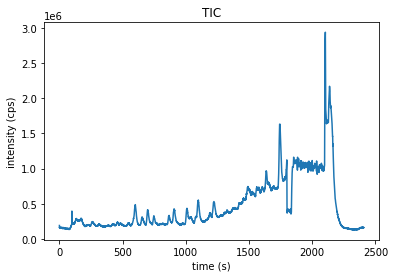

In [16]:
import matplotlib.pyplot as plt
# plot retention times and intensities and add labels
plt.plot(retention_times, intensities)

plt.title('TIC')
plt.xlabel('time (s)')
plt.ylabel('intensity (cps)')

plt.show()

### Assuming time in seconds, view where peaks should be located

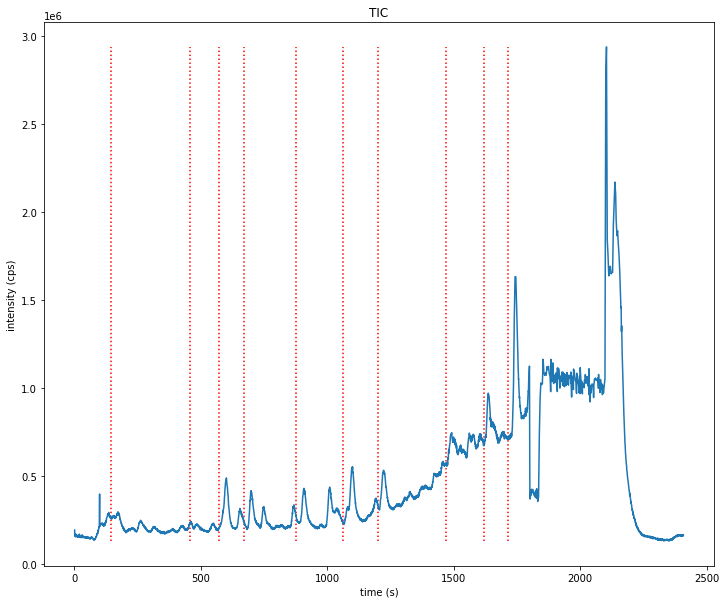

In [19]:
import matplotlib.pyplot as plt
# plot retention times and intensities and add labels
plt.figure(figsize=(12,10))
plt.plot(retention_times, intensities)

for i in lst.index:
  plt.vlines(lst.loc[i, 'Time']*60, 
              ymin=min(intensities), ymax=max(intensities), 
              colors='r', linestyles='dotted')
plt.title('TIC')
plt.xlabel('time (s)')
plt.ylabel('intensity (cps)')

plt.show()

### Define a function for, given chromatogram with MS2 events, search for peaks in a reference table (lst in this example) and return all MS2 peaks that are inside any time window in the reference

In [86]:
import warnings

def getMatchingMS2(lst, exp):
  """
  Searches for MS2 events inside a reference table with time windows.  
  Parameters:
  -------------------
  lst: pandas.DataFrame
    Reference table with peak time windows  
  exp: pyopenms.MSExperiment
    Spectra object from pyopenms
  -------------------
  Returns:
    Nested list with reference table index, scan number, 
    precursor mass and retention time
  """
  ms2 = []
  for spec in exp:
    if spec.getMSLevel() == 2:
      rt = spec.getRT()
      idx = (lst['Sec Begin'] <= rt) & (lst['Sec End'] >= rt)
      if idx.sum()==1:
        ind = lst[idx].index.values[0]
      elif idx.sum()>1:
        warnings.warn("Overlaping time windows, selecting first match.")
        ind = lst[idx].index.values[0]
      else:
        continue
      pr = spec.getPrecursors()[0].getMZ()
      scan = int(spec.getNativeID().replace('scan=', '')) - 1
      ms2.append([ind, scan, pr, rt])
  return ms2

### Execute function and obtain time match for each entry in your reference table. Notice that we can only find scans (expect multiple scans for each compound) for entries 0, 6 and 8. There are masses that don't match.

In [87]:
getMatchingMS2(lst, exp)

[[0, 283, 268.099761962891, 146.342],
 [0, 286, 268.104125976563, 147.866],
 [0, 288, 268.100219726563, 148.88],
 [0, 290, 268.103912353516, 149.894],
 [0, 292, 268.101593017578, 150.908],
 [0, 294, 268.103485107422, 151.924],
 [0, 296, 268.099670410156, 152.938],
 [0, 298, 268.105987548828, 153.952],
 [0, 300, 268.098236083984, 154.967],
 [6, 2368, 284.13427734375, 1210.434],
 [6, 2370, 306.116394042969, 1211.448],
 [8, 3190, 405.252471923828, 1629.755],
 [8, 3192, 405.255035400391, 1630.77],
 [8, 3193, 427.236999511719, 1631.272]]

In [88]:
lst.iloc[[0,6,8], :]

,Compound Name,Time,Time Tolerance,Mass Begin,Mass End,Sec Begin,Sec End
0,NaN,2.4,0.2,268.10,NaN,132.0,156.0
6,NaN,20.0,0.2,267.11,NaN,1188.0,1212.0
8,NaN,27.0,0.2,405.26,NaN,1608.0,1632.0


In [79]:
# How to double check the precursor corresponds to correct scan
exp.getSpectrum(283).getPrecursors()[0].getMZ()

268.099761962891

In [81]:
# How to get fragmentation spectra
# Note: The same process can be applied to DDA experiments
# that is how you would compare DDA with list, counting
# how many scans per compound are detected, how many peaks in average by spectrum
# average intensity, number of noisy peaks, etc
exp.getSpectrum(283).get_peaks()

(array([  91.98730469,   93.58641815,   94.00708771,   94.47754669,
         109.04628754,  109.09923553,  110.82141876,  118.08288574,
         119.03271484,  119.15242767,  119.22390747,  119.35688019,
         119.87486267,  119.99895477,  120.20241547,  120.64900208,
         121.21790314,  135.07640076,  136.0632019 ,  136.19577026,
         136.38511658,  136.47525024,  136.72627258,  136.8508606 ,
         136.91308594,  137.05519104,  137.16584778,  137.24311829,
         137.68756104,  137.78892517,  138.03897095,  140.12709045,
         148.80758667,  152.40385437,  163.15956116,  170.04664612,
         264.19000244,  267.86172485,  268.11209106,  269.0932312 ,
         274.21868896,  301.22052002,  306.43292236,  314.20285034,
         316.3371582 ,  417.43243408,  714.82263184, 1397.02539062,
        1472.96105957]),
 array([  39.,    9.,  132.,   10.,   72.,   45.,   10.,   14.,  622.,
          15.,   19.,   10.,   15.,   37.,   14.,   11.,   18.,   35.,
        1192.,   

In [85]:
exp